In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
from helpers import printm

NUMBER_OF_PHOTOS = 16

In [2]:
def get_text(original, img, cnt_all, start, line, size):
  #Find the closeset contour to the start point
  prime_cnt = sorted(cnt_all, key=lambda cnt: abs(cv.pointPolygonTest(cnt,start,True)))[0]

  take_x = lambda dot: dot[0][0]
  take_y = lambda dot: dot[0][1]

  #Find coordinate of squre
  y_0 = min(prime_cnt, key=take_y)[0][1] + line
  x_0 = min(prime_cnt, key=take_x)[0][0] + line
  y_1 = max(prime_cnt, key=take_y)[0][1] - line
  x_1 = max(prime_cnt, key=take_x)[0][0] - line

  center_y = y_0 + (y_1 - y_0)//2
  center_x = x_0 + (x_1 - x_0)//2

  resize = lambda image: cv.resize(image, (size, size), interpolation = cv.INTER_CUBIC)
  return map(resize, [original[y_0: center_y, x_0: center_x],
                      original[y_0: center_y, center_x: x_1],
                      original[center_y: y_1, x_0: center_x],
                      original[center_y: y_1, center_x: x_1]])

In [3]:
def standartize(dataset):
  output_dataset = []
  for img in dataset:
    new_img = []
    for row in img:
      for pixel in row:
        value = int(abs(255-((0.3 * pixel[0]) + (0.59 * pixel[1]) + (0.11 * pixel[2]))))
        new_img.append(value if value > 70 else 0)
    output_dataset.append(new_img)
  return output_dataset

In [4]:
def convert_to_standart(path):
    dataset = []
    names = [path] if not isinstance(path, list) else path
    for name in names:
        image = cv.imread(name)
        #cv2_imshow(image)

        #Left upper angle
        START_1 = (0, 0)

        #Right upper angle
        START_2 = (len(image[0]), 0)

        #Line width
        LINE = 14

        #Size of digit
        SIZE = 28

        #Process image
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        blur = cv.GaussianBlur(gray, (5,5), 0)
        thresh = cv.adaptiveThreshold(blur, 255, 1, 1, 11, 2)

        #Get contours of image
        contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

        #Get rid of dots and other lines that defenetly can not have area
        #and be squres that we are searching for
        contours = list(filter(lambda cnt: cv.contourArea(cnt) > 1000, contours))
        
        full = list(get_text(image, thresh, contours, START_1, LINE, SIZE)) + list(get_text(image, thresh, contours, START_2, LINE, SIZE))
        dataset += standartize(full)
    return dataset

In [5]:
dataset = convert_to_standart([f"data/photos/{ind}.jpg" for ind in range(1, NUMBER_OF_PHOTOS+1)])

In [6]:
labels = [1, 2, 3, 7, 4, 5, 6, 8, 9, 0, 1, 2,
          3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4,
          5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6,
          7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8,
          9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0,
          1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2,
          3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4,
          5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6,
          7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8,
          9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0,
          1, 2, 3, 4, 5, 6, 7, 8]

In [7]:
rocketbook = pd.DataFrame(columns=[list(range(1, len(dataset[0])+1))], data=dataset)
rocketbook["label"] = labels

In [8]:
rocketbook.to_csv("data/handwritten.csv", index=False)

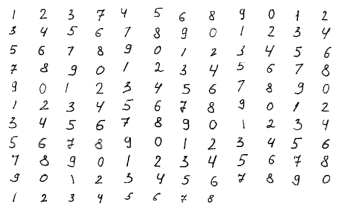

In [9]:
printm(dataset)